## Homework 4

Use this notebook as a starter

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [3]:
# !wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv

## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [4]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

In [5]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


Some of the features are encoded as numbers. Use the following code to de-code them:

In [6]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [7]:
df[['income', 'assets', 'debt']].describe().loc['max', :]

income    99999999.0
assets    99999999.0
debt      99999999.0
Name: max, dtype: float64

In [8]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [9]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [10]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [11]:
df.dtypes

seniority     int64
home         object
time          int64
age           int64
marital      object
records      object
job          object
expenses      int64
income        int64
assets        int64
debt          int64
amount        int64
price         int64
default       int64
dtype: object

In [12]:
numerical_columns = [
    'seniority',
    'time',
    'age',
    'expenses',
    'income',
    'assets',
    'debt',
    'amount',
    'price'
]

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [13]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [14]:
y_train = df_train[['default']]
y_val = df_val[['default']]
y_test = df_test[['default']]


del df_train['default']
del df_val['default']
del df_test['default']

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the default variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

In [15]:
y = y_train.loc[:, 'default']
y_ = y == 1

for col in numerical_columns:
    tpr, fpr = [], []
    for threshold in np.linspace(min(df_train.loc[:, col]), max(df_train.loc[:, col]), 100):
        detP = df_train.loc[:, col] < threshold
        tpr.append(sum(detP & y_)/sum(y_))  # TP/P, aka recall
        fpr.append(sum(detP & (~y_))/sum((~y_)))  # FP/N
    
    print('col =', col, 'auc =', auc(fpr, tpr).round(3))


col = seniority auc = 0.709
col = time auc = 0.439
col = age auc = 0.57
col = expenses auc = 0.501
col = income auc = 0.681
col = assets auc = 0.643
col = debt auc = 0.501
col = amount auc = 0.408
col = price auc = 0.495


##### Answer: `seniority`

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [16]:
work_columns = ['seniority', 'income', 'assets', 'records', 'job', 'home']

In [17]:
df_train[work_columns]

,seniority,income,assets,records,job,home
1877,12,102,0,no,fixed,private
1803,4,143,0,no,fixed,other
3400,0,295,6000,no,fixed,owner
3529,6,114,3500,no,fixed,owner
1721,12,0,15000,no,freelance,owner
...,...,...,...,...,...,...
2436,0,0,0,no,freelance,rent
1956,6,250,0,no,fixed,rent
91,9,105,0,yes,fixed,parents
3602,0,149,3000,no,others,parents


In [18]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[work_columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(df_val[work_columns].to_dict(orient='records'))
X_test = dv.transform(df_test[work_columns].to_dict(orient='records'))


model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train.values.ravel())

y_pred = model.predict_proba(X_val)[:, 1]

In [19]:
print(roc_auc_score(y_val.values.ravel(), y_pred).round(3))

0.812


In [20]:
fpr, tpr, thresholds = roc_curve(y_val.values.ravel(), y_pred)
auc(fpr, tpr).round(3)

0.812

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

##### Answer: `0.812`

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [21]:
thresholds = np.linspace(0, 1, 101)
p_list = []
r_list = []

for t in thresholds:
    actual_positive = (y_val == 1).values.ravel()
    actual_negative = (y_val == 0).values.ravel()
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
  
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    
    p_list.append(p)
    r_list.append(r)
    
#     print('t =', t.round(2), 'precision =', p.round(3)) #, 'recall =', r.round(3))

/var/folders/ll/z_xx4nvj6418xxgtn8q3jk2h0000gn/T/ipykernel_80872/563797458.py:18: RuntimeWarning: invalid value encountered in long_scalars
  p = tp / (tp + fp)


[]

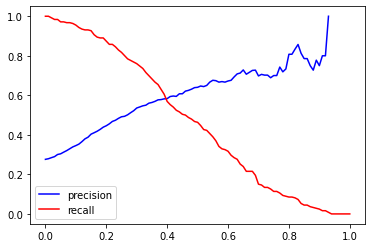

In [22]:
plt.plot(thresholds, p_list, label='precision', color='blue')
plt.plot(thresholds, r_list, label='recall', color='red')
plt.legend()
plt.plot()

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

##### Answer: `0.4`

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [23]:
thresholds = np.linspace(0, 1, 101)
f1_list = []

for t in thresholds:
    actual_positive = (y_val == 1).values.ravel()
    actual_negative = (y_val == 0).values.ravel()
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
  
#     print('tp =', tp, 'tp + fp =', tp + fp)
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    
    f1 = 2 * p * r / (p + r)
    f1_list.append(f1)

/var/folders/ll/z_xx4nvj6418xxgtn8q3jk2h0000gn/T/ipykernel_80872/3938904195.py:18: RuntimeWarning: invalid value encountered in long_scalars
  p = tp / (tp + fp)


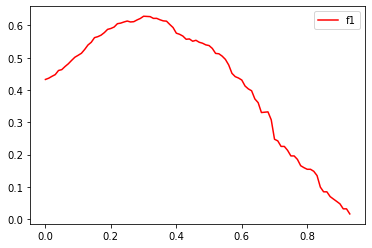

In [24]:
plt.plot(thresholds, f1_list, label='f1', color='red')
plt.legend()
plt.show()

At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

##### Answer: `0.3`

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [25]:
n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train_kfold = df_full_train.iloc[train_idx]
    df_val_kfold = df_full_train.iloc[val_idx]

    y_train_kfold = df_train_kfold[['default']].values
    y_val_kfold = df_val_kfold[['default']].values

    del df_train_kfold['default']
    del df_val_kfold['default']
    
    
    dv = DictVectorizer(sparse=False)
    train_dict = df_train_kfold[work_columns].to_dict(orient='records')
    X_train_kfold = dv.fit_transform(train_dict)
    X_val_kfold = dv.transform(df_val_kfold[work_columns].to_dict(orient='records'))


    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_kfold, y_train_kfold.ravel())

    y_pred_kfold = model.predict_proba(X_val_kfold)[:, 1]

    auc = roc_auc_score(y_val_kfold, y_pred_kfold)
    scores.append(auc)

print('std_scores =', np.std(scores).round(4))

std_scores = 0.0146


How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

##### Answer: `0.0146`

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std

In [27]:
n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []
for c_value in [0.01, 0.1, 1, 10]:
    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train_kfold = df_full_train.iloc[train_idx]
        df_val_kfold = df_full_train.iloc[val_idx]

        y_train_kfold = df_train_kfold[['default']].values
        y_val_kfold = df_val_kfold[['default']].values

        del df_train_kfold['default']
        del df_val_kfold['default']


        dv = DictVectorizer(sparse=False)
        train_dict = df_train_kfold[work_columns].to_dict(orient='records')
        X_train_kfold = dv.fit_transform(train_dict)
        X_val_kfold = dv.transform(df_val_kfold[work_columns].to_dict(orient='records'))


        model = LogisticRegression(solver='liblinear', C=c_value, max_iter=1000)
        model.fit(X_train_kfold, y_train_kfold.ravel())

        y_pred_kfold = model.predict_proba(X_val_kfold)[:, 1]

        auc = roc_auc_score(y_val_kfold, y_pred_kfold)
        scores.append(auc)

    print('C =', c_value, 'scores =', np.mean(scores).round(3), 'std_scores =', np.std(scores).round(4))

C = 0.01 scores = 0.808 std_scores = 0.0118
C = 0.1 scores = 0.813 std_scores = 0.0137
C = 1 scores = 0.814 std_scores = 0.0146
C = 10 scores = 0.814 std_scores = 0.0146


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

##### Answer: `1`

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.